In [10]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

def get_objpoints_imgpoints(camera_cal='camera_cal/calibration*.jpg'):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(camera_cal)
    img_size = None
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        if not img_size:
            img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints, img_size

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

In [2]:
def camera_calibrate_coefficients(camera_cal):
    objpoints, imgpoints, img_size = get_objpoints_imgpoints(camera_cal)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dist  

In [4]:
def undistort_img(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)    
    return dst

In [5]:
def show_images(img, dst, cmap1=None, cmap2=None, title1='Original Image', title2='Undistorted Image'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img, cmap=cmap1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(dst, cmap=cmap2)
    ax2.set_title(title2, fontsize=30)

In [6]:
mtx, dist = camera_calibrate_coefficients('camera_cal/calibration*.jpg')

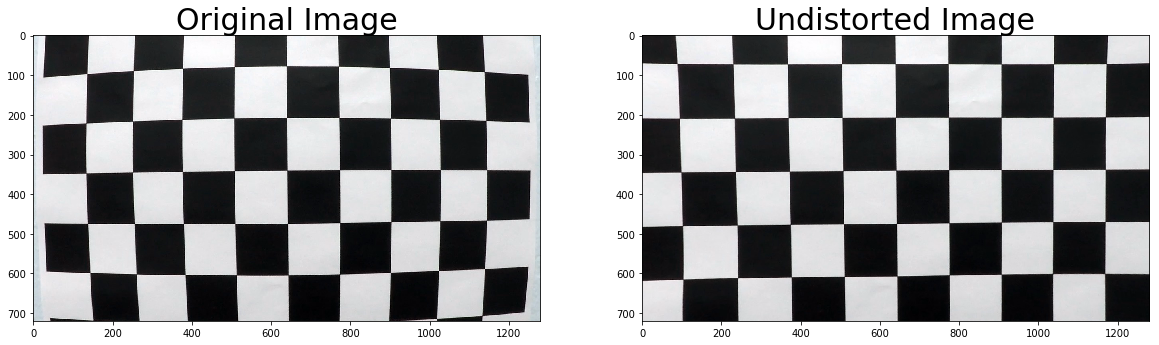

In [7]:
test_img = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'
img = cv2.imread(test_img)
dst = undistort_img(img, mtx, dist)
show_images(img, dst)

In [8]:
def abs_sobel_thresh(img_channel, orient='x', sobel_kernel=3, thresh=(10, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [9]:
def mag_thresh(img_channel, sobel_kernel=3, mag_thresh=(30, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [10]:
def combine_thresh(image_channel, ksize = 3):
    gradx = abs_sobel_thresh(image_channel, orient='x', sobel_kernel=ksize, thresh=(15, 255)) 
    grady = abs_sobel_thresh(image_channel, orient='y', sobel_kernel=ksize, thresh=(15, 255)) 
    mag_binary = mag_thresh(image_channel, sobel_kernel=ksize, mag_thresh=(30, 255)) 

    combined = np.zeros_like(mag_binary)
    combined[(((gradx == 1) & (grady == 1)) & (mag_binary == 1))] = 1
    return combined

In [11]:
def detect_lane_boarder(img, ksize = 3):
    image = np.copy(img)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_binary = combine_thresh(s_channel, ksize)
    l_binary = combine_thresh(l_channel, ksize)
    combined = np.zeros_like(s_binary)
    combined[((s_binary == 1) | (l_binary == 1))] = 1
    return combined

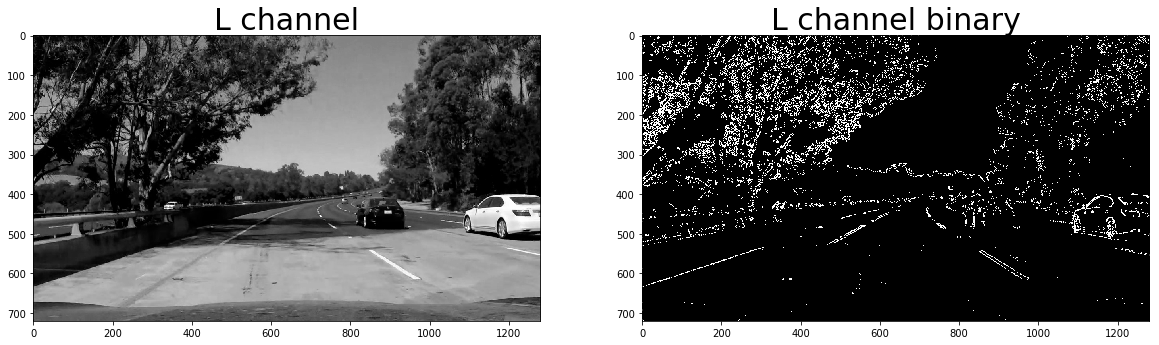

In [53]:
test_img = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/test_images/test5.jpg'
image = mpimg.imread(test_img)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
s_binary = combine_thresh(s_channel, 3)
l_binary = combine_thresh(l_channel, 3)
show_images(l_channel, l_binary, cmap1='gray', cmap2='gray', title1='L channel', title2='L channel binary')

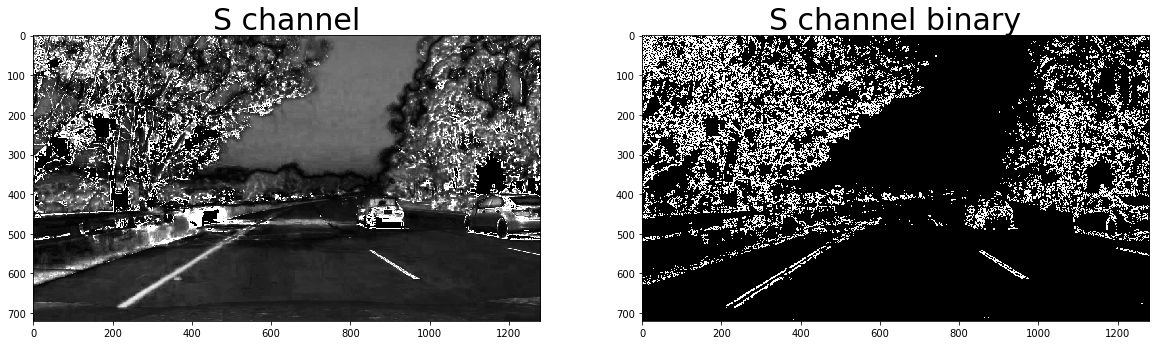

In [54]:
show_images(s_channel, s_binary, cmap1='gray', cmap2='gray', title1='S channel', title2='S channel binary')

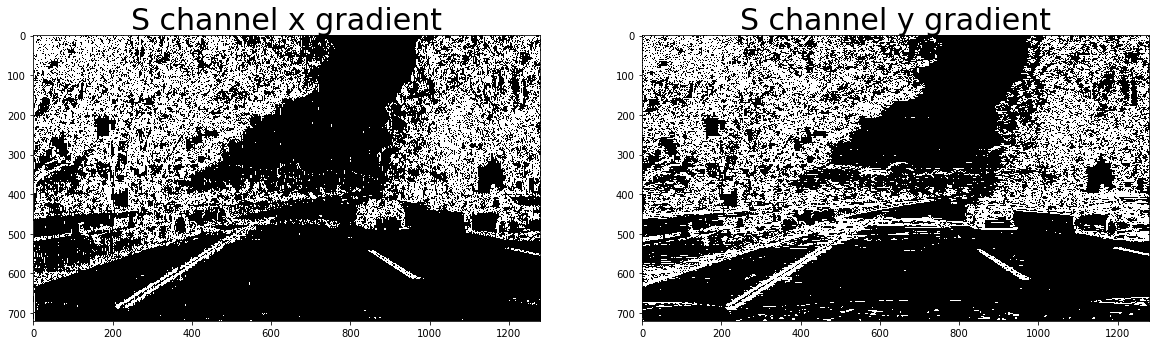

In [61]:
s_x_b = abs_sobel_thresh(s_channel, orient='x')
s_y_b = abs_sobel_thresh(s_channel, orient='y')
show_images(s_x_b, s_y_b, cmap1='gray', cmap2='gray', title1='S channel x gradient', title2='S channel y gradient')

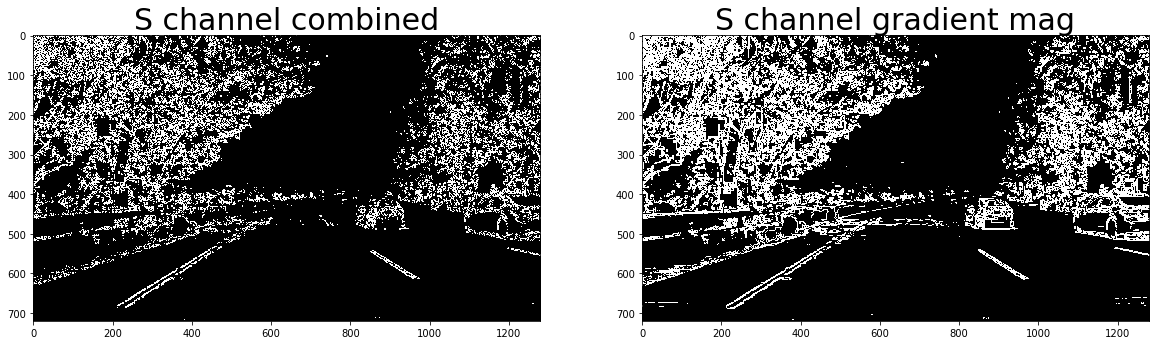

In [62]:
s_mag_b = mag_thresh(s_channel)
show_images(s_binary, s_mag_b, cmap1='gray', cmap2='gray', title1='S channel combined', title2='S channel gradient mag')

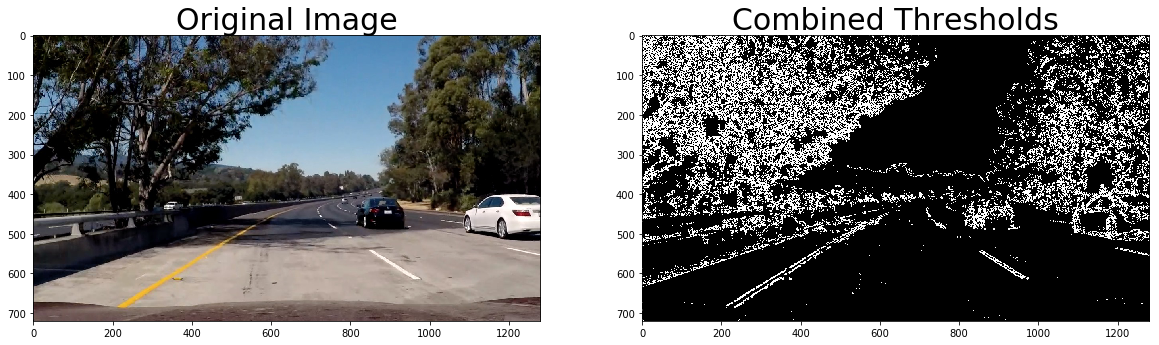

In [55]:
test_img = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/test_images/test5.jpg'
image = mpimg.imread(test_img)
combined_binary = detect_lane_boarder(image, 3)
show_images(image, combined_binary, cmap1=None, cmap2='gray', title1='Original Image', title2='Combined Thresholds')

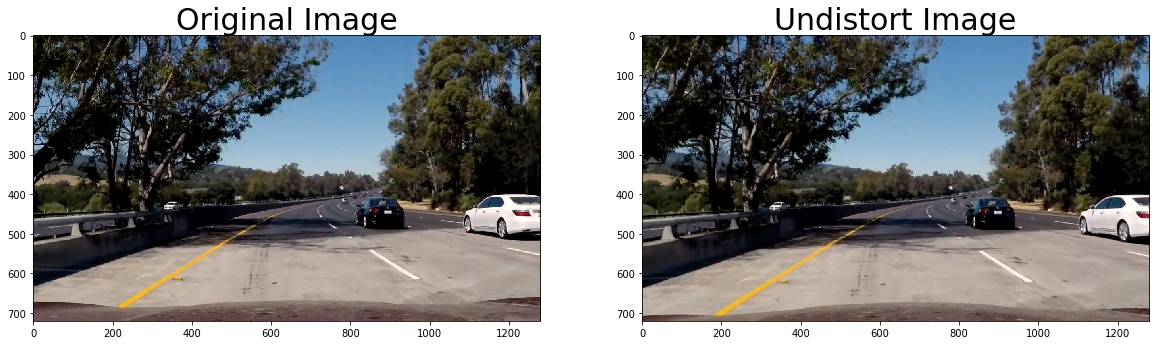

In [56]:
test_img = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/test_images/test5.jpg'
image = mpimg.imread(test_img)
undistort = undistort_img(image, mtx, dist)
show_images(image, undistort, title1='Original Image', title2='Undistort Image')

In [14]:
 def get_perspective_matrix(src, dst):
    src = np.float32(src)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32(dst)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    return M

def warp_image(img, M, img_size=(1280, 720)):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [15]:
def get_src_dst():
    src = [[190, 720], [585, 455], [700, 455], [1120, 720]]
    dst = [[190, 720], [190, 0], [1120, 0], [1120, 720]]
    return src, dst

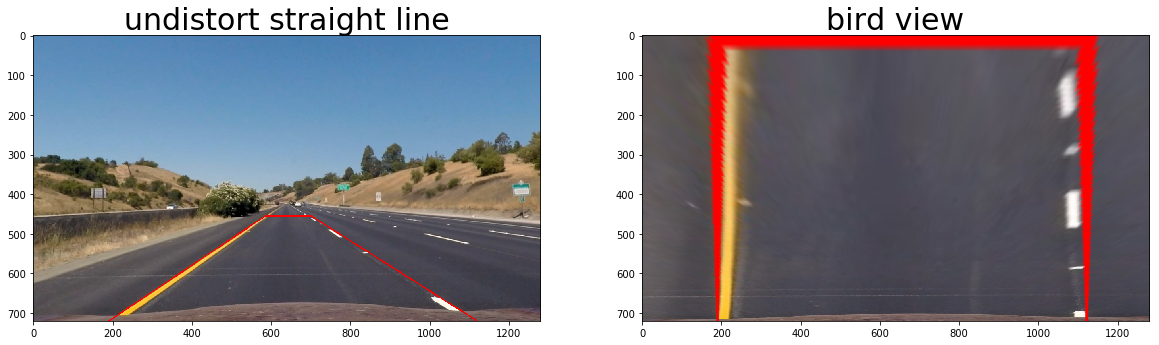

In [16]:
straight_line1 = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg'
original = mpimg.imread(straight_line1)
undistort = undistort_img(original, mtx, dist)
cv2.line(undistort, (585, 455), (700, 455), (255, 0, 0), 2)
cv2.line(undistort, (585, 455), (190, 720), (255, 0, 0), 2)
cv2.line(undistort, (700, 455), (1120, 720), (255, 0, 0), 2)
cv2.line(undistort, (190, 720), (1120, 720), (255, 0, 0), 2)

src, dst = get_src_dst()
M = get_perspective_matrix(src, dst)
img_size = (undistort.shape[1], undistort.shape[0])

bird_view = warp_image(undistort, M)
show_images(undistort, bird_view, title1="undistort straight line", title2="bird view")

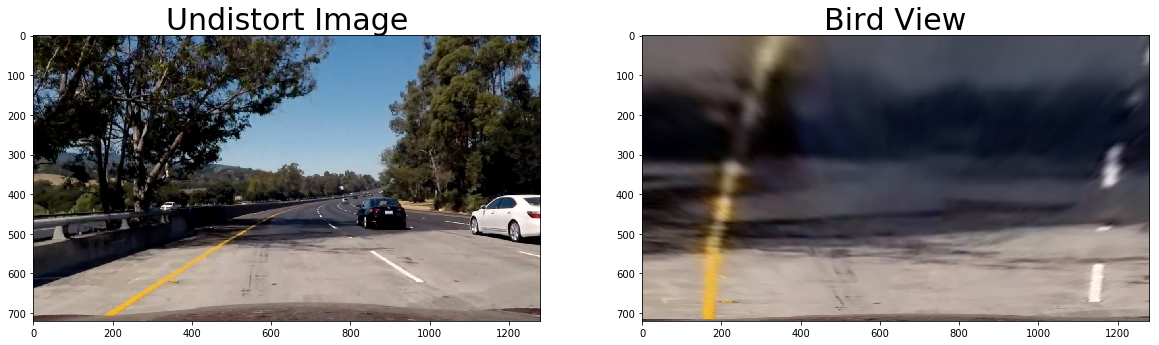

In [57]:
test_img = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/test_images/test5.jpg'
org_img = mpimg.imread(test_img)
undistort = undistort_img(org_img, mtx, dist)
bird_view = warp_image(undistort, M)
show_images(undistort, bird_view, title1="Undistort Image", title2="Bird View")

In [17]:
def calculate_curvature(left_fit_cr, right_fit_cr):
    y_eval = 720
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_lane_with_sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)    
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    curvature = calculate_curvature(left_fit_cr, right_fit_cr)
    
    y_bottom = 720
    x_center = 1280/2
    left_start = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]
    right_end = right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2]
    shift = ((left_start+right_end)/2 - x_center)*xm_per_pix
    
    results = {'shift': shift, 'curvature': curvature, 'left_lane_inds': left_lane_inds, 
              'right_lane_inds': right_lane_inds, 'left_fit': left_fit, 'right_fit': right_fit}
    
    return results 

In [19]:
def find_lane_within_margin(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    curvature = calculate_curvature(left_fit_cr, right_fit_cr)
    
    y_bottom = 720
    x_center = 1280/2
    left_start = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]
    right_end = right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2]
    shift = ((left_start+right_end)/2 - x_center)*xm_per_pix
    
    results = {'shift': shift, 'curvature': curvature, 'left_lane_inds': left_lane_inds, 
              'right_lane_inds': right_lane_inds, 'left_fit': left_fit, 'right_fit': right_fit}
    
    return results

In [20]:
def put_text(img, shift, curvature):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)
    cv2.putText(img, 'Left curvature {:.2f} km'.format(curvature[0]/1000.0), (50, 50),
                font, font_scale, font_color, 2)
    cv2.putText(img, 'right curvature {:.2f} km'.format(curvature[1]/1000.0), (50, 100),
                font, font_scale, font_color, 2)
    if shift < 0:
        cv2.putText(img, 'Vehicle is {:.2f} m right from the center'.format(abs(shift)), (50, 150), font,
                    font_scale, font_color, 2)
    else:
        cv2.putText(img, 'Vehicle is {:.2f} m left from the center'.format(abs(shift)), (50, 150), font,
                    font_scale, font_color, 2)

In [21]:
def draw_lane(org_img, M, InvM, mtx, dist):
    global left_fit
    global right_fit
    undistort = undistort_img(org_img, mtx, dist)
    undistort_binary = detect_lane_boarder(undistort, 3)
    binary_warped = warp_image(undistort_binary, M)

    results = find_lane_within_margin(binary_warped, left_fit, right_fit) \
        if (left_fit is not None) and (right_fit is not None) else \
        find_lane_with_sliding_window(binary_warped)
    # create output array of specified dimention
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    lane_lines = np.zeros_like(out_img)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_fit = results['left_fit']
    right_fit = results['right_fit']
    left_lane_inds = results['left_lane_inds']
    right_lane_inds = results['right_lane_inds']
    shift = results['shift']
    curvature = results['curvature']
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    road_pts = np.hstack((left_line_window, right_line_window))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([road_pts]), (0,255, 0))
    # Color in left and right line pixels
    window_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    window_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #
    result = cv2.addWeighted(undistort, 1.0, np.uint8(warp_image(window_img, InvM)), 0.3, 0)
    put_text(result, shift, curvature)
    return result

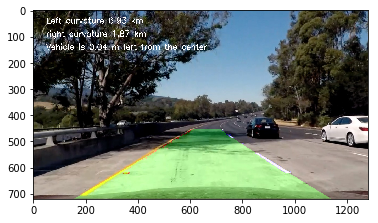

In [58]:
from PIL import Image
M = get_perspective_matrix(src, dst)
InvM = get_perspective_matrix(dst, src)
test_img = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/test_images/test5.jpg'
org_img = mpimg.imread(test_img)
processed_img = draw_lane(org_img, M, InvM, mtx, dist)
processed_img = Image.fromarray(processed_img)
processed_img.save('/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/output_images/output_example.png')
plt.imshow(processed_img)

In [45]:
def draw_in_bird_view(binary_warped, res):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = res['left_fit']
    right_fit = res['right_fit']
    left_lane_inds = res['left_lane_inds']
    right_lane_inds = res['right_lane_inds']
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    N = left_fitx.shape[0]
    left_points = np.ndarray(shape=(N,2), dtype=np.int32, order='F')
    left_points[:,0] = left_fitx
    left_points[:,1] = ploty
    right_points = np.ndarray(shape=(N,2), dtype=np.int32, order='F')
    right_points[:,0] = right_fitx
    right_points[:,1] = ploty
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]]
    cv2.polylines(out_img, [left_points], False, (255,255,0), thickness=3, lineType=8)
    cv2.polylines(out_img, [right_points], False, (255,255,0), thickness=3, lineType=8)
    return out_img

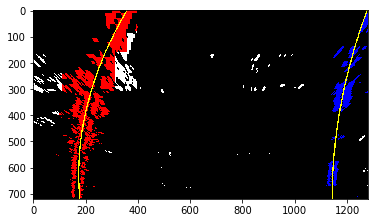

In [59]:
test_img = '/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/test_images/test5.jpg'
org_img = mpimg.imread(test_img)
undistort = undistort_img(org_img, mtx, dist)
undistort_binary = detect_lane_boarder(undistort, 3)
binary_warped = warp_image(undistort_binary, M)
res = find_lane_with_sliding_window(binary_warped)
processed_img = draw_in_bird_view(binary_warped, res)
processed_img = Image.fromarray(processed_img)
processed_img.save('/Users/wuyang/Downloads/self_driving_car/CarND-Advanced-Lane-Lines/output_images/color_fit_lane.png')
plt.imshow(processed_img)